**Nama : Clarissa Beatrice Kosasih  
NIM : 2702209350**

---
Link Video : [Video-Autoencoder](https://binusianorg-my.sharepoint.com/personal/clarissa_kosasih001_binus_ac_id/_layouts/15/onedrive.aspx?id=%2Fpersonal%2Fclarissa%5Fkosasih001%5Fbinus%5Fac%5Fid%2FDocuments%2FSemester%204%2FDeep%20Learning%2FFINALS%2FCase%202%2DAutoencoder&ga=1)

# Unzip Folder

In [ ]:
# Unzip data

import zipfile
import os

zip_path = 'A23.zip'       
extract_path = 'A23'  

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

# print("Unzip selesai!")

In [ ]:
import os
from PIL import Image

import numpy as np
import random
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [ ]:
SEED = 42
tf.keras.utils.set_random_seed(SEED)
tf.random.set_seed(SEED)

## Cek Images yang Rusak

In [ ]:
dataset_path = "A23\A_23"

for root, dirs, files in os.walk(dataset_path):
    for file in files:
        filepath = os.path.join(root, file)
        try:
            with Image.open(filepath) as img:
                img.verify()
        except Exception as e:
            print(f"Hapus file: {filepath}")
            os.remove(filepath)

Tidak ada image yang rusak.

# A. EDA

## Jumlah dan Nama Kelas

In [ ]:
from collections import defaultdict
import matplotlib.image as mpimg

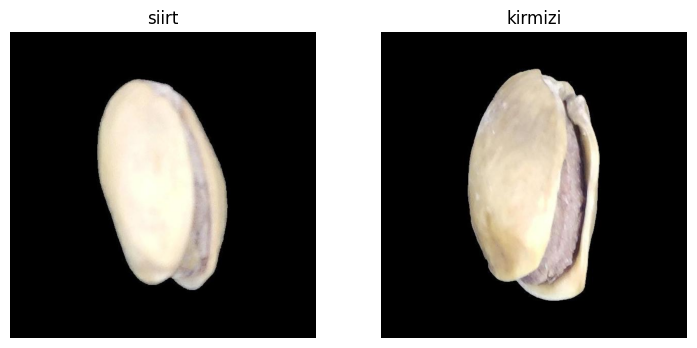

In [ ]:
image_files = [f for f in os.listdir(dataset_path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]

# Kelompokkan file berdasarkan kata pertama dari nama file (nama kelas)
class_images = defaultdict(list)

for filename in image_files:
    class_name = filename.split()[0].lower()  # ambil kata pertama, e.g. 'kirmizi'
    class_images[class_name].append(filename)


# Tampilkan 1 gambar dari setiap kelas
plt.figure(figsize=(15, 10))

for i, (class_name, files) in enumerate(class_images.items()):
    img_path = os.path.join(dataset_path, files[0])  # ambil satu contoh gambar per kelas
    img = mpimg.imread(img_path)

    plt.subplot(3, 4, i + 1)
    plt.imshow(img)
    plt.title(class_name)
    plt.axis('off')

plt.tight_layout()
plt.show()

Terdapat 2 kelas di data ini: kirmizi dan siirt.

## Total Images

In [ ]:
print(f'Banyak data: {len(image_files)}\n')
for class_name, files in class_images.items():
    print(f'Banyak data {class_name}: {len(files)}')

Banyak data: 1074

Banyak data siirt: 458
Banyak data kirmizi: 616


Terdapat total 1.074 gambar dalam folder 'A_23'. Gambar-gambar ini terbagi ke dalam dua kelas, yaitu kirmizi sebanyak 616 gambar dan siirt sebanyak 458 gambar.

## Cek Width dan Height Image

In [ ]:
sizes = []
for file in image_files:
    file_path = os.path.join(dataset_path, file)
    with Image.open(file_path) as img:
        sizes.append(img.size)

widths, heights = zip(*sizes)

In [ ]:
print(f"Lebar  - min: {min(widths)}, max: {max(widths)}, mean: {sum(widths)//len(widths)} px")
print(f"Tinggi - min: {min(heights)}, max: {max(heights)}, mean: {sum(heights)//len(heights)} px")

Lebar  - min: 600, max: 600, mean: 600 px
Tinggi - min: 600, max: 600, mean: 600 px


Semua gambar memiliki widths dan heights yang konsisten: 600 x 600 px.

## Menampilkan 5 Gambar Random

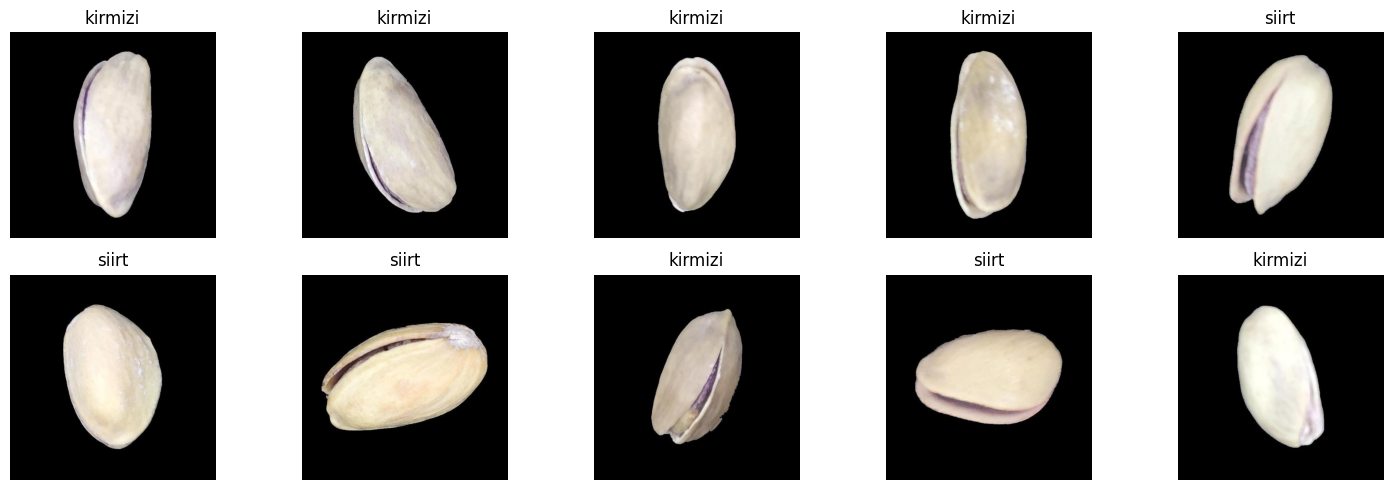

In [ ]:
plt.figure(figsize=(15, 5))

random_filenames = random.sample(image_files, 10) # pilih 10 random file

for i, filename in enumerate(random_filenames):
    path = os.path.join(dataset_path, filename)
    img = keras.utils.load_img(path)

    plt.subplot(2, 5, i + 1)
    plt.imshow(img)
    plt.title(filename.split()[0])
    plt.axis('off')

plt.tight_layout()
plt.show()

Tidak ditemukan masalah pada gambar yang ditampilkan.

## Cek Pixel Range dan Mode

In [ ]:
pixel_mins = []
pixel_maxs = []
modes = []

for file in image_files[:]:
    file_path = os.path.join(dataset_path, file)
    with Image.open(file_path) as img:
        arr = np.array(img)
        pixel_mins.append(arr.min())
        pixel_maxs.append(arr.max())
        modes.append(img.mode)

# Print hasilnya
print(f"Rentang nilai piksel: min={min(pixel_mins)}, max={max(pixel_maxs)}")
print("Mode warna unik yang ditemukan:", set(modes))

Rentang nilai piksel: min=0, max=255
Mode warna unik yang ditemukan: {'RGB'}


- Rentang nilai piksel adalah 0 sampai 255 sehingga nanti perlu scaling menjadi 0 sampai dengan 1.
- Semua gambar bermode RGB.

# B. Data Preprocessing

## Split Data

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
# Ambil full path -> kirmizi 1.jpg diubah jadi A_23/kirmizi 1.jpg
full_paths = [os.path.join(dataset_path, f) for f in image_files]

In [ ]:
train_files, temp_files = train_test_split(full_paths, test_size=0.2, random_state=SEED) # Split 80% train, 20% temp

val_files, test_files = train_test_split(temp_files, test_size=0.5, random_state=SEED) # Split jadi 10% val, 10% test

print(f"Train size: {len(train_files)}\nVal size: {len(val_files)}\nTest size: {len(test_files)}")
print(f'---\nTotal Image: {len(train_files) + len(val_files) + len(test_files)}')

Train size: 859
Val size: 107
Test size: 108
---
Total Image: 1074


Jumlah image yang dibaca sudah sama dengan jumlah.

## Resize dan Scaling

In [ ]:
image_size = (100, 100)
batch_size = 32

def resize_and_scaling(file_path):
    img = tf.io.read_file(file_path)
    img = tf.image.decode_jpeg(img, channels=3) # RGB
    img = tf.image.resize(img, image_size) # resize image
    img = tf.cast(img, tf.float32) / 255.0 # scaling jadi 0-1
    return img

Function ini untuk resize dan scaling image.

In [ ]:
def PREFETCH(file_paths, batch_size=32):
    ds = tf.data.Dataset.from_tensor_slices(file_paths)
    ds = ds.map(resize_and_scaling)
    ds = ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return ds

train_ds = PREFETCH(train_files)
val_ds   = PREFETCH(val_files)
test_ds  = PREFETCH(test_files)

Prefetch digunakan untuk mempercepat training dengan cara menyiapkan data lebih awal saat CPU atau GPU sedang sibuk.

## Noise

In [ ]:
def add_noise(images, noise_factor=0.2):
    noisy = images + noise_factor * tf.random.normal(shape=tf.shape(images)) # tambahkan noise ke image (normal distribution)
    noisy = tf.clip_by_value(noisy, 0., 1.) # clip jadi 0 s.d 1

    return noisy, images

In [ ]:
# Add Noise
train_ds_noisy = train_ds.map(add_noise)
val_ds_noisy   = val_ds.map(add_noise)
test_ds_noisy  = test_ds.map(add_noise)

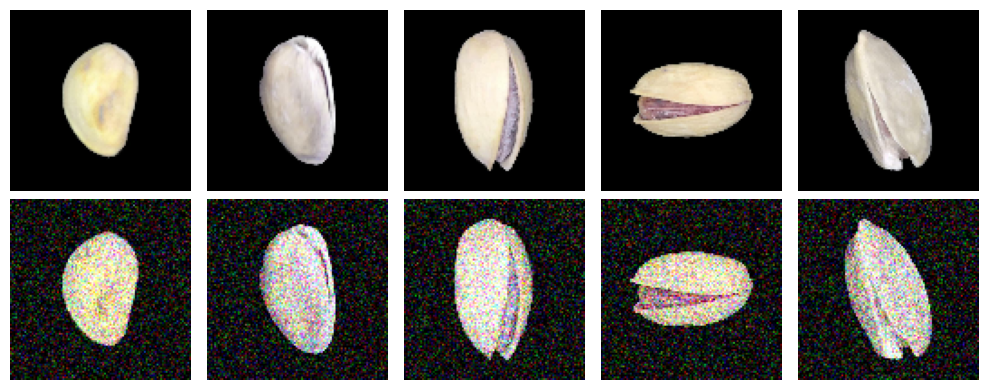

In [ ]:
# Visualisasi

noisy_batch, original_batch = next(iter(train_ds_noisy)) # ambil 1 batch
noisy_images = noisy_batch.numpy()
original_images = original_batch.numpy()

num_images = 5
plt.figure(figsize=(num_images * 2, 4))

for i in range(num_images):
    # Original
    plt.subplot(2, num_images, i + 1)
    plt.imshow(original_images[i])
    plt.axis("off")

    # Noisy
    plt.subplot(2, num_images, i + 1 + num_images)
    plt.imshow(noisy_images[i])
    plt.axis("off")

plt.tight_layout()
plt.show()

# C. Autoencoder Baseline

In [ ]:
from tensorflow.keras import layers, losses, metrics
from tensorflow.keras.models import Model

In [ ]:
class Denoise(Model):
    def __init__(self):
        super(Denoise, self).__init__()

        # Encoder
        self.encoder = tf.keras.Sequential([
            layers.Input(shape=(100, 100, 3)),                         
            layers.Conv2D(32, (3, 3), activation='relu', padding='same'),    
            layers.MaxPooling2D((2, 2), padding='same'),                   
            layers.Conv2D(64, (3, 3), activation='relu', padding='same'),   
            layers.MaxPooling2D((2, 2), padding='same'),                    
            layers.Conv2D(64, (3, 3), activation='relu', padding='same')    
        ])

        # Decoder
        self.decoder = tf.keras.Sequential([
            layers.UpSampling2D((2, 2)),                                     
            layers.Conv2D(32, (3, 3), activation='relu', padding='same'),   
            layers.UpSampling2D((2, 2)),                                     
            layers.Conv2D(3, (3, 3), activation='sigmoid', padding='same')  
        ])

    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [ ]:
baseline = Denoise()
baseline.compile(optimizer='adam', loss=losses.MeanSquaredError(), metrics=[metrics.MeanAbsoluteError()])

In [ ]:
print('ENCODER:')
baseline.encoder.summary()
print('\n\nDECODER:')
baseline.decoder.summary()

ENCODER:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 100, 100, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 50, 50, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 50, 50, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 25, 25, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 25, 25, 64)     │        36,928 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 56,320 (220.00 KB)

 Trainable params: 56,320 (220.00 KB)

 Non-trainable params: 0 (0.00 B)



DECODER:


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ up_sampling2d (UpSampling2D)    │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_1 (UpSampling2D)  │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history_baseline = baseline.fit(
    train_ds_noisy,
    epochs=10,
    validation_data=val_ds_noisy
)

Epoch 1/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 53s 2s/step - loss: 0.1222 - mean_absolute_error: 0.2942 - val_loss: 0.0051 - val_mean_absolute_error: 0.0280
Epoch 2/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 44s 2s/step - loss: 0.0048 - mean_absolute_error: 0.0261 - val_loss: 0.0043 - val_mean_absolute_error: 0.0238
Epoch 3/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 40s 1s/step - loss: 0.0042 - mean_absolute_error: 0.0232 - val_loss: 0.0039 - val_mean_absolute_error: 0.0227
Epoch 4/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - loss: 0.0039 - mean_absolute_error: 0.0221 - val_loss: 0.0036 - val_mean_absolute_error: 0.0217
Epoch 5/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 40s 1s/step - loss: 0.0035 - mean_absolute_error: 0.0208 - val_loss: 0.0031 - val_mean_absolute_error: 0.0199
Epoch 6/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 42s 1s/step - loss: 0.0029 - mean_absolute_error: 0.0185 - val_loss: 0.0025 - val_mean_absolute_error: 0.0171
Epoch 7/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 40s 1s/step - loss: 0.0026 - mean_absolute_error: 0.0171 - val_loss: 0.002

# D. Autoencoder Modifikasi

Dari hasil evaluasi model baseline, dapat dilihat bahwa hasil denoise tidak terlalu mampu menangkap detail gambar dengan tajam. Oleh karena itu, dilakukan beberapa modifikasi:
1. Memakai Skip Connection (U-Net)
    > proses encoding cenderung menghilangkan detail lokal sehingga dengan Skip Connection, detail yang hilang saat encoding bisa dipulihkan saat decoding.
2. Mengganti Upsampling jadi Conv2DTranspose, yang bisa mempertajam karena kebalikan pooling, artinya memperbesar ukuran.

In [ ]:
class DenoiseUNet(Model):
    def __init__(self):
        super(DenoiseUNet, self).__init__()

        # Encoder layers
        self.conv1 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')
        self.pool1 = layers.MaxPooling2D((2, 2), padding='same')

        self.conv2 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')
        self.pool2 = layers.MaxPooling2D((2, 2), padding='same')

        self.conv3 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')

        # Decoder layers
        self.up1 = layers.Conv2DTranspose(64, (3, 3), strides=2, activation='relu', padding='same')
        self.concat1 = layers.Concatenate()
        self.conv4 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')

        self.up2 = layers.Conv2DTranspose(32, (3, 3), strides=2, activation='relu', padding='same')
        self.concat2 = layers.Concatenate()
        self.conv5 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')

        self.output_layer = layers.Conv2D(3, (3, 3), activation='sigmoid', padding='same')

    def call(self, inputs):
        # Encoder
        x1 = self.conv1(inputs)
        x2 = self.pool1(x1)
        x3 = self.conv2(x2)
        x4 = self.pool2(x3)
        bottleneck = self.conv3(x4)

        # Decoder
        x = self.up1(bottleneck)
        x = self.concat1([x, x3])
        x = self.conv4(x)

        x = self.up2(x)
        x = self.concat2([x, x1])
        x = self.conv5(x)

        return self.output_layer(x)


In [ ]:
modification = DenoiseUNet()

# data dummy
dummy_input = tf.random.normal(shape=(1, 100, 100, 3))
modification(dummy_input)

# modification.build(input_shape=(None, 100, 100, 3))

modification.compile(optimizer='adam', loss=losses.MeanSquaredError(), metrics=[metrics.MeanAbsoluteError()])

In [ ]:
modification.summary(expand_nested=True)

Model: "denoise_u_net_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_11 (Conv2D)              │ (1, 100, 100, 32)      │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (1, 50, 50, 64)        │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (1, 25, 25, 64)        │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_2              │ (1, 50, 50, 64)        │        36,928 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ concatenate_2 (Concatenate)     │ (1, 50, 50, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (1, 50, 50, 64)        │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_3              │ (1, 100, 100, 32)      │        18,464 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ concatenate_3 (Concatenate)     │ (1, 100, 100, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (1, 100, 100, 32)      │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (1, 100, 100, 3)       │           867 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 204,835 (800.14 KB)

 Trainable params: 204,835 (800.14 KB)

 Non-trainable params: 0 (0.00 B)

Meskipun `model.summary()` menampilkan tanda tanya "?" pada output MaxPooling2D, ini bukanlah sebuah error. Bukti bahwa layer ini berfungsi dengan benar dapat diverifikasi pada layer berikutnya, yang menunjukkan dimensi inputnya telah berkurang setengahnya (misalnya dari 100x100 menjadi 50x50). Dengan demikian, ini hanyalah keterbatasan visual dari fungsi `summary()` dan tidak memengaruhi performa atau hasil pelatihan model.

In [ ]:
history_modification = modification.fit(
    train_ds_noisy,
    epochs=10,
    validation_data=val_ds_noisy
)

Epoch 1/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 116s 4s/step - loss: 0.1311 - mean_absolute_error: 0.3073 - val_loss: 0.0036 - val_mean_absolute_error: 0.0225
Epoch 2/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 138s 4s/step - loss: 0.0030 - mean_absolute_error: 0.0203 - val_loss: 0.0025 - val_mean_absolute_error: 0.0189
Epoch 3/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 143s 4s/step - loss: 0.0023 - mean_absolute_error: 0.0182 - val_loss: 0.0020 - val_mean_absolute_error: 0.0175
Epoch 4/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 138s 4s/step - loss: 0.0019 - mean_absolute_error: 0.0168 - val_loss: 0.0016 - val_mean_absolute_error: 0.0154
Epoch 5/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 140s 4s/step - loss: 0.0015 - mean_absolute_error: 0.0144 - val_loss: 0.0013 - val_mean_absolute_error: 0.0135
Epoch 6/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 104s 4s/step - loss: 0.0013 - mean_absolute_error: 0.0131 - val_loss: 0.0013 - val_mean_absolute_error: 0.0132
Epoch 7/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 143s 4s/step - loss: 0.0012 - mean_absolute_error: 0.0126 - val_loss

# E. Evaluasi

## Evaluasi Baseline Model

In [ ]:
from skimage.metrics import structural_similarity as ssim
import numpy as np

In [ ]:
def evaluate_ssim(model, dataset):
    total_ssim = 0
    total_images = 0

    for noisy, clean in dataset:
        denoised = model.predict(noisy)

        # Konversi ke NumPy
        clean = clean.numpy()

        for c, d in zip(clean, denoised):
            score = ssim(c, d, data_range=1.0, channel_axis=-1)
            total_ssim += score
            total_images += 1

    avg_ssim = total_ssim / total_images
    print(f"SSIM rata-rata: {avg_ssim:.4f}")
    return avg_ssim

In [ ]:
ssim_baseline = evaluate_ssim(baseline, test_ds_noisy)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 530ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 355ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 319ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 392ms/step
SSIM rata-rata: 0.9162


In [ ]:
def show_denoising_result(model, dataset, n=5):
    # Ambil satu batch dari dataset
    noisy_imgs, clean_imgs = next(iter(dataset))

    denoised_imgs = model.predict(noisy_imgs)

    # Tampilkan n gambar pertama
    plt.figure(figsize=(n * 3, 8))

    for i in range(n):
        # Noisy input
        ax = plt.subplot(3, n, i + 1)
        plt.imshow(noisy_imgs[i])
        plt.title("Noisy")
        plt.axis("off")

        # Denoised output
        ax = plt.subplot(3, n, i + 1 + n)
        plt.imshow(denoised_imgs[i])
        plt.title("Denoised")
        plt.axis("off")

        # Ground truth
        ax = plt.subplot(3, n, i + 1 + 2 * n)
        plt.imshow(clean_imgs[i])
        plt.title("Original")
        plt.axis("off")

    plt.tight_layout()
    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 376ms/step


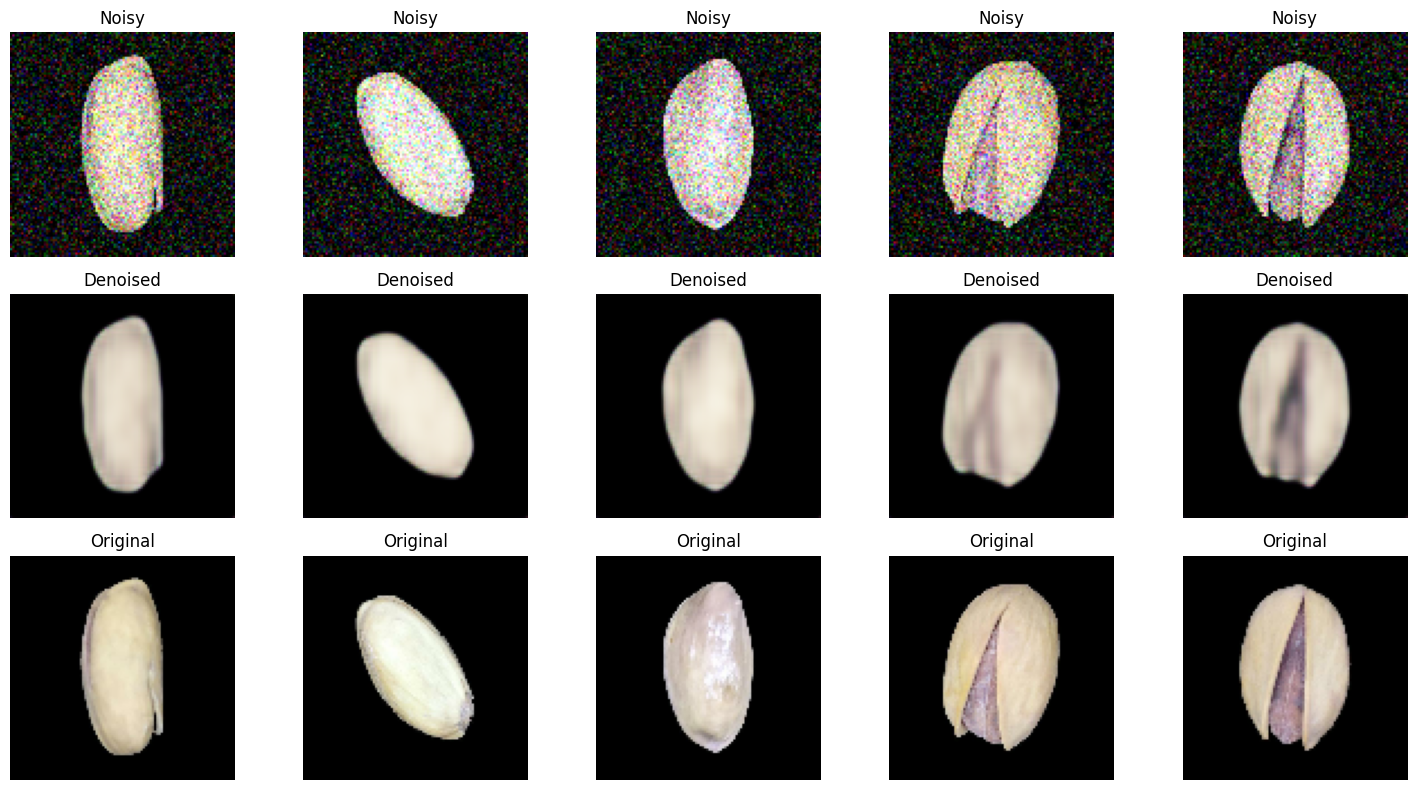

In [ ]:
show_denoising_result(baseline, test_ds_noisy, n=5)

In [ ]:
def plot_training_history(history):
  plt.figure(figsize=(12, 5))

  plt.subplot(1, 2, 1)
  plt.plot(history.history['loss'], label='Train Loss')
  plt.plot(history.history['val_loss'], label='Val Loss')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.title('Training vs Validation Loss')
  plt.legend()
  plt.grid(True)

  plt.subplot(1, 2, 2)
  plt.plot(history.history['mean_absolute_error'], label='Train MAE')
  plt.plot(history.history['val_mean_absolute_error'], label='Val MAE')
  plt.xlabel('Epoch')
  plt.ylabel('MAE')
  plt.title('Training vs Validation MAE')
  plt.legend()
  plt.grid(True)

  plt.show()

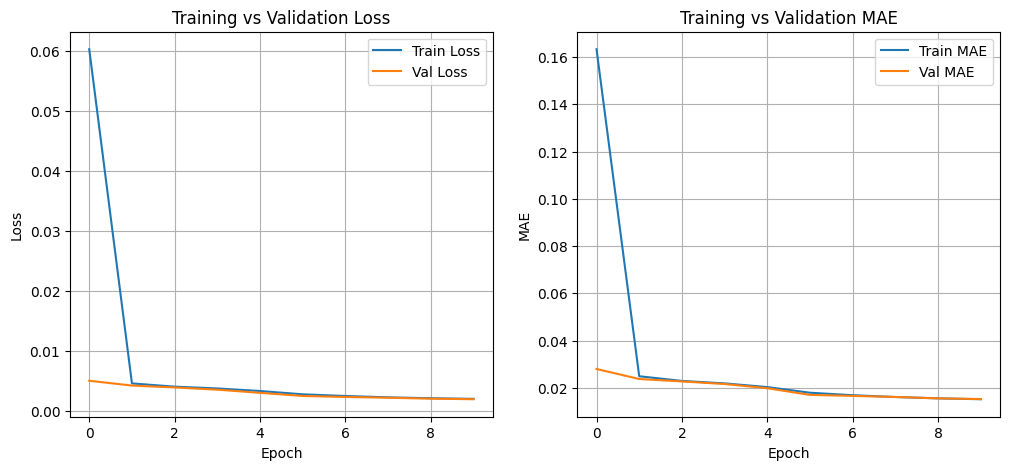

In [ ]:
plot_training_history(history_baseline)

Train Loss dan Validation Loss sangat dekat , serta Train MAE dan Validation MAE sangat dekat. Ini menunjukkan bahwa model telah mencapai generalisasi yang baik tanpa overfitting atau underfitting.

## Evaluasi Model Modifikasi

In [ ]:
ssim_modif = evaluate_ssim(modification, test_ds_noisy)

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 946ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 537ms/step
SSIM rata-rata: 0.9361


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 933ms/step


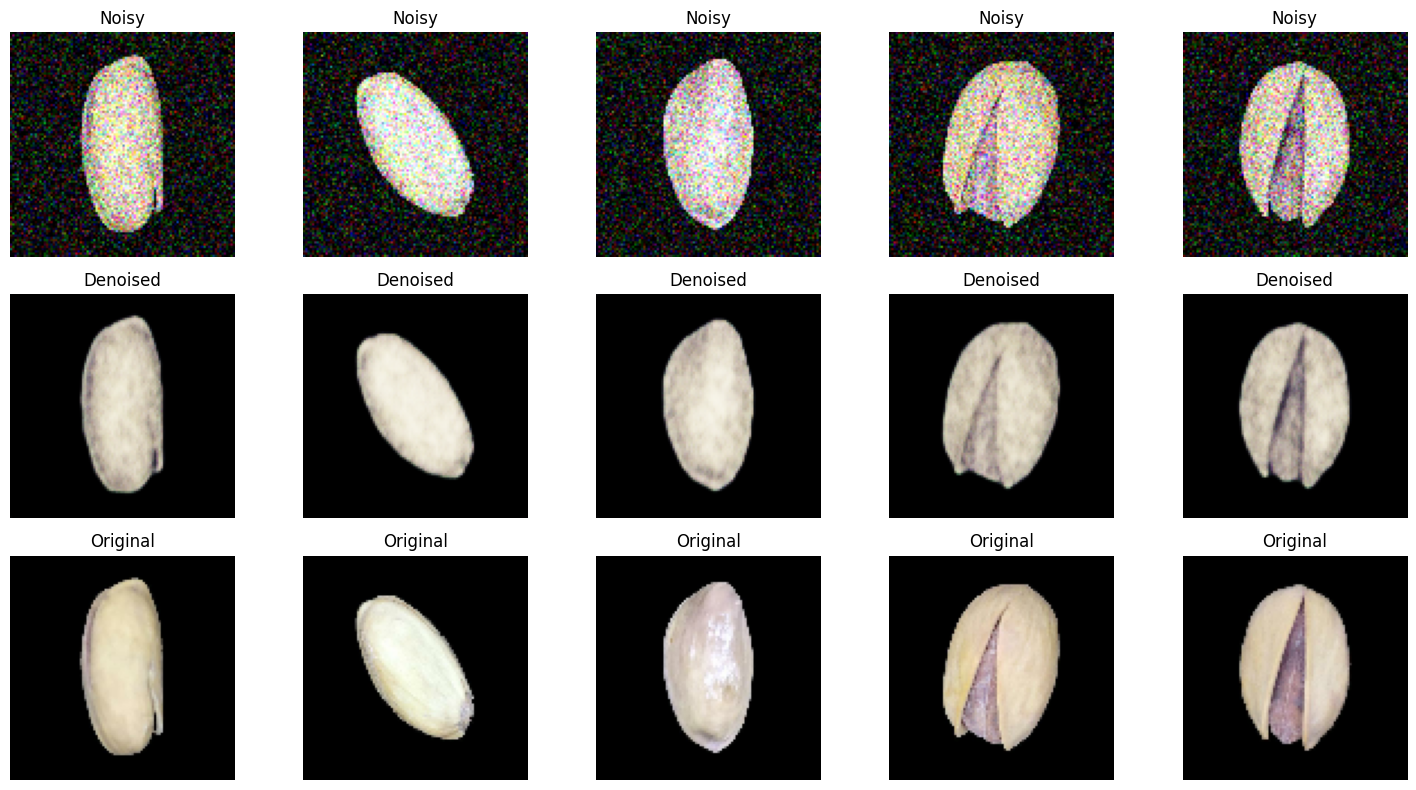

In [ ]:
show_denoising_result(modification, test_ds_noisy, n=5)

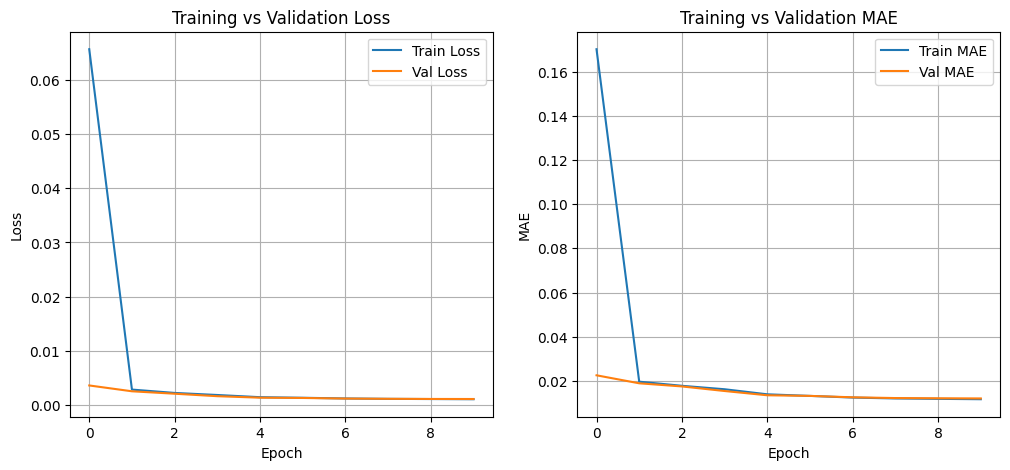

In [ ]:
plot_training_history(history_modification)

Sama halnya dengan plot baseline, model telah mencapai generalisasi yang baik tanpa overfitting atau underfitting.

In [ ]:
comparison = pd.DataFrame({
    'Model': ['Baseline', 'Modifikasi'],
    'SSIM': [ssim_baseline, ssim_modif]
})

In [ ]:
comparison

,Model,SSIM
0,Baseline,0.916185
1,Modifikasi,0.936060


Model Modifikasi menghasilkan SSIM yang lebih tinggi dibanding Model Baseline. Hal ini menunjukkan bahwa hasil denoise dari model modifikasi memiliki kualitas visual yang lebih baik dan lebih mirip dengan gambar asli, terutama dalam hal struktur dan detail tekstur. 